# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 6
# Reg-Logistic Regression, ROC, and Data Imputation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): Scott Shaffer 

Enrollment Status (109A, 121A, 209A, or E109A): 109A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline

## Automated Breast Cancer Detection

In this homework, we will consider the problem of early breast cancer detection from X-ray images. Specifically, given a candidate region of interest (ROI) from an X-ray image of a patient's breast, the goal is to predict if the region corresponds to a malignant tumor (label 1) or is normal (label 0). The training and test data sets for this problem is provided in the file `hw6_dataset.csv`. Each row in these files corresponds to a ROI in a patient's X-ray, with columns 1-117 containing features computed using standard image processing algorithms. The last column contains the class label, and is based on a radiologist's opinion or a biopsy. This data was obtained from the KDD Cup 2008 challenge.

The data set contain a total of 69,098 candidate ROIs, of which only 409 are malignant, while the remaining are all normal. 

*Note*: be careful of reading/treating column names and row names in this data set.

## Question 1: Beyond Classification Accuracy


0.  Split the data set into a training set and a testing set.  The training set should be 75% of the original data set, and the testing set 25%.  Use `np.random.seed(9001)`.

1. Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation. 
    1. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients? 
    2. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?
    
For applications with imbalanced class labels, in this case when there are many more healthy subjects ($Y=0$) than those with cancer ($Y=1$), the classification accuracy may not be the best metric to evaluate a classifier's performance. As an alternative, we could analyze the confusion table for the classifier. 

<ol start="3">
<li> Compute the confusion table for both the fitted classifier and the classifier that predicts all 0's.</li>
<li> Using the entries of the confusion table compute the *true positive rate* and the *true negative rate* for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.</li>
<li> What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?</li>
</ol>
*Hint:* You may use the `metrics.confusion_matrix` function to compute the confusion matrix for a classification model.

In [8]:
np.random.seed(9001)
df = pd.read_csv('./data/hw6_dataset.csv')
msk = np.random.rand(len(df)) < 0.75
data_train = df[msk]
data_test = df[~msk]

ytrain = data_train.iloc[:,-1]
Xtrain = data_train.drop(data_test.columns[len(data_test.columns)-1], axis=1)

ytest = data_test.iloc[:,-1]
Xtest = data_test.drop(data_test.columns[len(data_test.columns)-1], axis=1)


In [17]:
logregcv = LogisticRegressionCV(penalty='l2')
logregcv.fit(Xtrain, ytrain)

print(logregcv.score(Xtest, ytest))

print(len(ytest))
all_values = len(ytest)
positive_values = np.count_nonzero(ytest)
print(np.count_nonzero(ytest))
print("Percent non-zero: ")
print(1.0-(positive_values/all_values))


0.995084269663
17088
104
Percent non-zero: 
0.9939138576779026


In [23]:
from sklearn.metrics import confusion_matrix

test_preds = logregcv.predict(Xtest)
print("Cancer cases predicted:")
print(np.count_nonzero(test_preds))
print("Actual cancer cases:")
print(positive_values)

print("Confusion Matrix:")
C = confusion_matrix(ytest, test_preds, labels=None)
print(C)

# From sklearn documentation: 
# the count of true negatives is C_{0,0}, false negatives is C_{1,0}, 
# true positives is C_{1,1} and false positives is C_{0,1}.

# Sensitivity or TPR = TP / P = TP / (TP + FN)
print("\nTrue Positive Rate:")
print(C[1][1] / (C[1][1] + C[1][0]))

# Specificity or TNR = TN / N = TN / (TN + FP)
print("\nTrue Negative Rate:")
print(C[0][0] / (C[0][0] + C[0][1]))

# FPR = FP / N = FP / (FP + TN)
print("\nFalse Positive Rate:")
print(C[0][1] / (C[0][1] + C[0][0]))


Cancer cases predicted:
36
Actual cancer cases:
104
Confusion Matrix:
[[16976     8]
 [   76    28]]

True Positive Rate:
0.269230769231

True Negative Rate:
0.999528968441

False Positive Rate:
0.000471031559114


#### Q: How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients? 

#### Q: Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?

#### Q: Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.

#### Q: What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?

False Positive Rate is the rate of false positives (do not have cancer, but the test is positive) out of all of the "actual negatives" -- so true negatives plus false positives. This can be written as FP/(TN+FP)

The True Negative Rate is the rate of true negatives (people who do not have cancer, and the test is negative) over all of the actual negatives. This is equal to TN/(TN+FP), or 1 - False Positive Rate (described above)

The True Positive Rate is the true positives over all the actual positives (people with cancer), so False Negatives + True Positives. The relationship between TPR and FPR/TNR is dependent on the classification model.



## Question 2: ROC Analysis

Another powerful diagnostic tool for class-imbalanced classification tasks is the Receiver Operating Characteristic (ROC) curve. Notice that the default logistic regression classifier in `sklearn` classifies a data point by thresholding the predicted class probability $\hat{P}(Y=1)$ at 0.5. By using a different threshold, we can adjust the trade-off between the true positive rate (TPR) and false positive rate (FPR) of the classifier. The ROC curve allows us to visualize this trade-off across all possible thresholds.


1. Display the ROC curve for the fitted classifier on the *test set*. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?

2.  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9
- Suppose a clinician told you that diagnosing a cancer patient as normal is *twice* as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold? 

- Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)? 

*Hint:* You may use the `metrics.roc_curve` function to compute the ROC curve for a classification model and the `metrics.roc_auc_score` function to compute the AUC for the model.

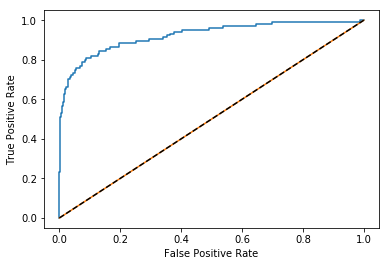

In [46]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plotROC(ytrue, ypreds):
    fpr, tpr, thresholds = roc_curve(ytrue, ypreds)
    plt.plot(fpr, tpr)

test_scores = logregcv.predict_proba(Xtest)[:,1]
yzeros = np.zeros(len(ytest))

plotROC(ytest, test_scores)
plotROC(ytest, yzeros)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()


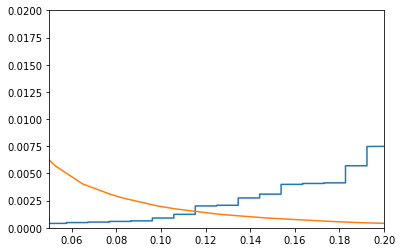

In [58]:
# Diagnosing a cancer patient as normal is twice as bad as diagnosing a normal patient with cancer
# False negative rate needs to be half false positive rate FNR = 1/2 FPR
# FNR = 1-TPR
# 1 - TPR = 1/2 FPR
fpr, tpr, thresholds = roc_curve(ytest, test_scores)
plt.plot(1-tpr, thresholds)
plt.plot(0.5*fpr, thresholds)
plt.xlim(0.05, 0.2)
plt.ylim(0.0, 0.02)
plt.show()



## Question 3: Missing data

In this problem you are given a different data set, `hw6_dataset_missing.csv`, that is  similar to the one you used above (same column definitions and same conditions), however this data set contains missing values. 

*Note*: be careful of reading/treating column names and row names in this data set as well, it *may* be different than the first data set.


1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1 (use `LogisticRegressionCV` again to retune).  Report the overall classification rate and TPR in the test set.
2. Restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via mean imputation.  Split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
3. Again restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
4. Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.



In [80]:
def split_data(df):
    msk = np.random.rand(len(df)) < 0.75
    data_train = df[msk]
    data_test = df[~msk]
    
    ytrain = data_train.iloc[:,-1]
    Xtrain = data_train.drop(data_test.columns[len(data_test.columns)-1], axis=1)

    ytest = data_test.iloc[:,-1]
    Xtest = data_test.drop(data_test.columns[len(data_test.columns)-1], axis=1)
    return (ytrain, Xtrain, ytest, Xtest)
    
def split_and_test(df):
    ytrain, Xtrain, ytest, Xtest = split_data(df)
    logregcv = LogisticRegressionCV(penalty='l2')
    logregcv.fit(Xtrain, ytrain)
    print(logregcv.score(Xtest, ytest))
    test_preds = logregcv.predict(Xtest)
    C = confusion_matrix(ytest, test_preds, labels=None)
    print(C)

    print("\nTrue Positive Rate:")
    print(C[1][1] / (C[1][1] + C[1][0]))


In [81]:
df = pd.read_csv('./data/HW6_dataset_missing.csv')
print(len(df))
df.dropna(axis=0, how='any', inplace=True)
print(len(df))
split_and_test(df)


24999
1436


/Users/rmitchell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.997237569061
[[361   0]
 [  1   0]]

True Positive Rate:
0.0
